# Asymptotics of Predictive Distributions

Following the predictive distributions used by Garelli et al in section 3.3

## Simulation study

- $x_1, ..., x_s$ of observed data, $s=50, 100, 500, 1000, 1500, 2000$ from a mixture of 3 shifted t-distributions with weights $w_1 = 0.3, w_2 = 0.1, w_3 = 0.6$, shifting constants $\mu_1 = -5, \mu_2 = 0, \mu_3 = 4$ and degrees of freedom $\nu = 3$.
- Run predictive resampling with $N = 50, 500, 5000$ and $B = 1000$. 
- $N$ is the number of samples we use to complete the observation.
- $B$ is the number of samples of $\theta$ we use to compute the predictive distribution. The distribution of $\theta$ is estimated using KDE methods.

In [2]:
import pymc as pm
######
# Creating the mixture model distribution
######
weights = [0.3, 0.1, 0.6]
mus = [-5, 0, 4]  # shifting constants
nus = [3, 3, 3]  # degrees of freedom
theoretical_mean = sum([w * mu for w, mu in zip(weights, mus)])

# Create the mixture model
comp_dists =[
    pm.StudentT.dist(nu=nus[0], mu=mus[0]),
    pm.StudentT.dist(nu=nus[1], mu=mus[1]),
    pm.StudentT.dist(nu=nus[2], mu=mus[2]),
]
real_model = pm.Mixture.dist(w=weights, comp_dists=comp_dists)


In [3]:
######
# Drawing the first observations
######
s = 50
x_obs = pm.draw(real_model, draws=s)

In [ ]:
import numpy as np
######
# Predictive Resampling for the parameter "mean of the data"
######
N = 500
B = 100
def theta_hat_func(x):
    """Computes estimated parameter theta"""
    return np.mean(x)


thetas = np.zeros(B)  # array to store thetas
# predictive_params = dict(
#     mu = np.mean(x_obs),
#     sigma = np.std(x_obs),
# )
for i in range(B):
    # x = x_obs
    mu = np.mean(x_obs)
    sigma = np.std(x_obs)
    alpha = pm.Normal.dist(mu=mu, sigma=sigma)
    for j in range(N):
        x_new = pm.draw(alpha, draws=1)
        mu = (s+j)*mu/(s+j+1) + x_new/(s+j+1)
        sigma = np.sqrt((s+j-1)*sigma**2/(s+j) + (x_new - mu)**2/(s+j+1))
        alpha = pm.Normal.dist(mu=mu, sigma=sigma)
        
        x = np.append(x, x_new)
    
    thetas[i] = theta_hat_func(x)


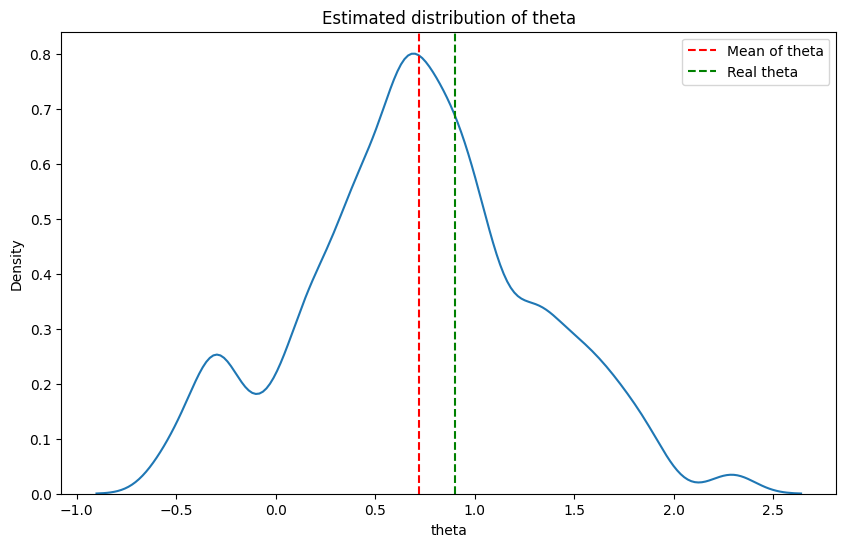

In [11]:
# plotting estimated kde of theta
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(thetas, bw_adjust=0.5)
plt.title("Estimated distribution of theta")
plt.xlabel("theta")
plt.ylabel("Density")
plt.axvline(np.mean(thetas), color='red', linestyle='--', label='Mean of theta')
plt.axvline(theoretical_mean, color='green', linestyle='--', label='Real theta')
plt.legend()
plt.show()

Bayesian Likelihood prior

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.676  0.602  -0.352    1.943      0.014    0.015    1986.0    1306.0   
sigma  4.121  0.419   3.404    4.946      0.010    0.010    1769.0    1137.0   

       r_hat  
mu       1.0  
sigma    1.0  


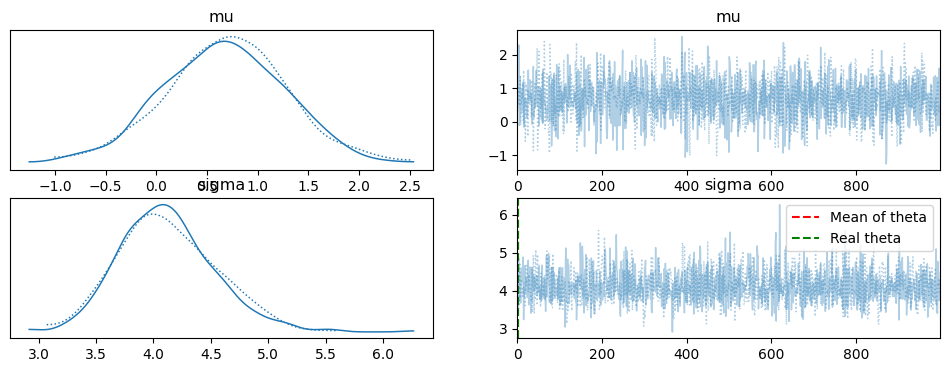

In [14]:
import arviz as az
import matplotlib.pyplot as plt
with pm.Model() as model_noninformative:
    # Priors (Non-informative, Jeffrey's priors)
    sigma = pm.HalfNormal('sigma', sigma=10)  # Weakly informative for variance
    mu = pm.Flat('mu')  # Flat prior for mean
    
    # Likelihood
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=x_obs)
    
    # Inference
    trace_noninformative = pm.sample(1000, tune=1000, cores=2)

# Summary and visualization
print(az.summary(trace_noninformative))
az.plot_trace(trace_noninformative)
plt.axvline(np.mean(thetas), color='red', linestyle='--', label='Mean of theta')
plt.axvline(theoretical_mean, color='green', linestyle='--', label='Real theta')
plt.legend()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     0.515  0.493  -0.405    1.422      0.011    0.012    1978.0    1281.0   
sigma  4.104  0.424   3.363    4.929      0.009    0.011    2086.0    1160.0   

       r_hat  
mu       1.0  
sigma    1.0  


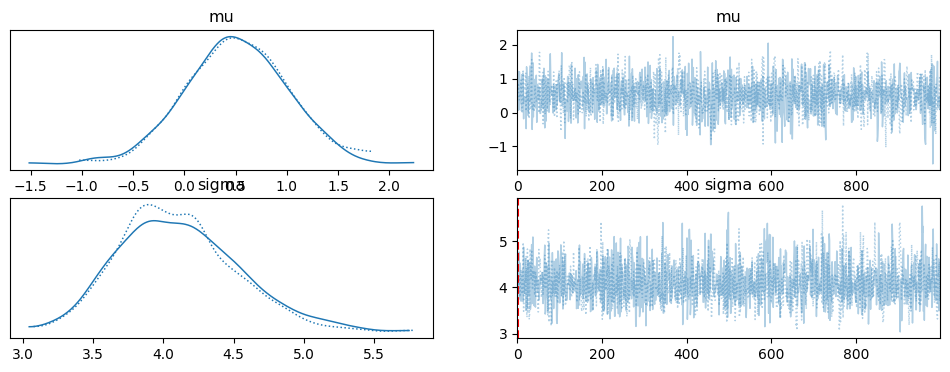

In [ ]:
with pm.Model() as model_normal_prior:
    # Priors
    sigma = pm.HalfNormal('sigma', sigma=10)  # Still need prior for variance
    mu = pm.Normal('mu', mu=0, sigma=1)  # Normal(0, 1) prior for mean
    
    # Likelihood





    # IS THE LIKELIHOOD CORRECT HERE??????
    likelihood = pm.Normal('likelihood', mu=mu, sigma=sigma, observed=x_obs)  # ATTN, make sure that the likelihood is correct here
    
    # Inference
    trace_normal_prior = pm.sample(1000, tune=1000, cores=2)

# Summary and visualization
print(az.summary(trace_normal_prior))
az.plot_trace(trace_normal_prior)
plt.axvline(np.mean(thetas), color='red', linestyle='--', label='Mean of theta')

<Figure size 3000x2000 with 0 Axes>

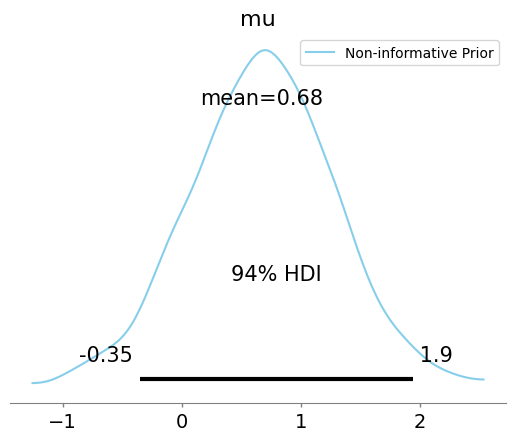

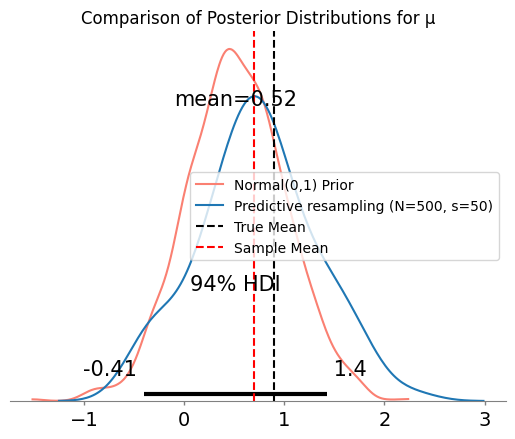

In [17]:
# comparing predictions
plt.figure(figsize=(30, 20))
az.plot_posterior(trace_noninformative, var_names=['mu'], label='Non-informative Prior', color='skyblue')
az.plot_posterior(trace_normal_prior, var_names=['mu'], label='Normal(0,1) Prior', color='salmon')
# az.plot_posterior(trace_empirical_bayes, var_names=['mu'], label='Empirical Bayes', color='lightgreen')
# Predictive resampling
sns.kdeplot(thetas, label=f"Predictive resampling (N={N}, s={s})")

# Add vertical lines for the means
plt.axvline(theoretical_mean, color='k', linestyle='--', label='True Mean')
plt.axvline(np.mean(x_obs), color='r', linestyle='--', label='Sample Mean')
plt.title('Comparison of Posterior Distributions for μ')
plt.legend(loc="best")
plt.show()

In [15]:
import scipy.stats as sts
datum = 1.5
mu_support = np.array([1.5, 1.6, 1.7, 1.8, 1.9])
likelihood_out = sts.norm.pdf(datum, mu_support, scale = 0.1)  # viewd as multiple pdf-s with different means
likelihood_out = likelihood_out / np.sum(likelihood_out)

data_obs = np.array([1.5, 1.6, 1.7, 1.8, 1.9])

likelihood = np.ones(mu_support.shape[0])
# Loop over all the data points
# and multiply the likelihood for each theta
# with the likelihood for the data point
for datum in data_obs:
    likelihood_out = sts.norm.pdf(datum, mu_support, scale = 0.1)
    likelihood_out = likelihood_out / np.sum(likelihood_out)
    likelihood *= likelihood_out
print("likelihood:", likelihood)


likelihood: [7.19645171e-09 1.30114899e-05 1.58512397e-04 1.30114899e-05
 7.19645171e-09]


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


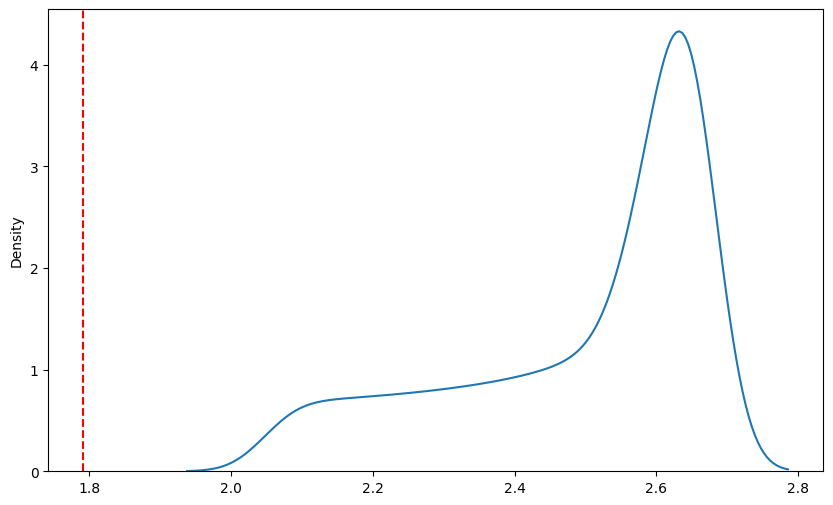

In [28]:
from src.predictions import *
import numpy as np
import matplotlib.pyplot as plt

#autoreaload
%load_ext autoreload
%autoreload 2

theta_support = np.linspace(1.5, 1.9, 50)

predictor = LikelihoodPriorPredictor(theta_support=theta_support)
data_obs=np.array([1.5, 1.7, 1.8, 1.9, 1.90, 1.95])

theta_dist = predictor.predict_theta(data_obs)

plt.figure(figsize=(10, 6))
import seaborn as sns
sns.kdeplot(theta_dist, bw_adjust=0.5)
# plt.plot(theta_support, theta_dist, label='Posterior')
plt.axvline(np.mean(data_obs), color='red', linestyle='--', label='Mean of theta')
plt.show()

In [20]:
from src.simulations import *

nus = [3, 3, 3]
mus = [-5, 0, 4]
weights = [0.3, 0.1, 0.6]
# Create the simulator
garelli_sim = TMixtureSimulator(
    n=1000,
    mus=mus,
    nus=nus,
    weights=weights,
)

garelli_data = garelli_sim.simulate()

In [21]:
theta_support = np.linspace(-5, 4, 50)  
predictor = LikelihoodPriorPredictor(theta_support=theta_support)

In [22]:
print(np.mean(garelli_data))
print(np.dot(weights, mus))

0.6636653460821349
0.8999999999999999


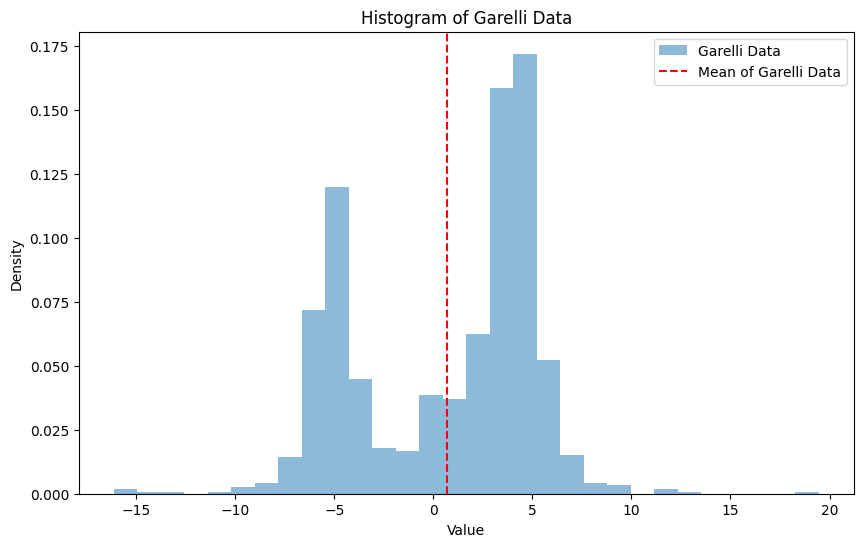

In [23]:
#plotting garelli data
plt.figure(figsize=(10, 6))
plt.hist(garelli_data, bins=30, density=True, alpha=0.5, label='Garelli Data')
plt.axvline(np.mean(garelli_data), color='red', linestyle='--', label='Mean of Garelli Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Histogram of Garelli Data')
plt.legend()
plt.show()

In [39]:
def theta_hat_func(x):
    """Computes estimated parameter theta"""
    return np.mean(x)

PRPredictor = PredictiveResamplingNormal(theta_hat_func)
pr_theta_dist = PRPredictor.predict_theta(data_obs=garelli_data, n_resamples=2000)

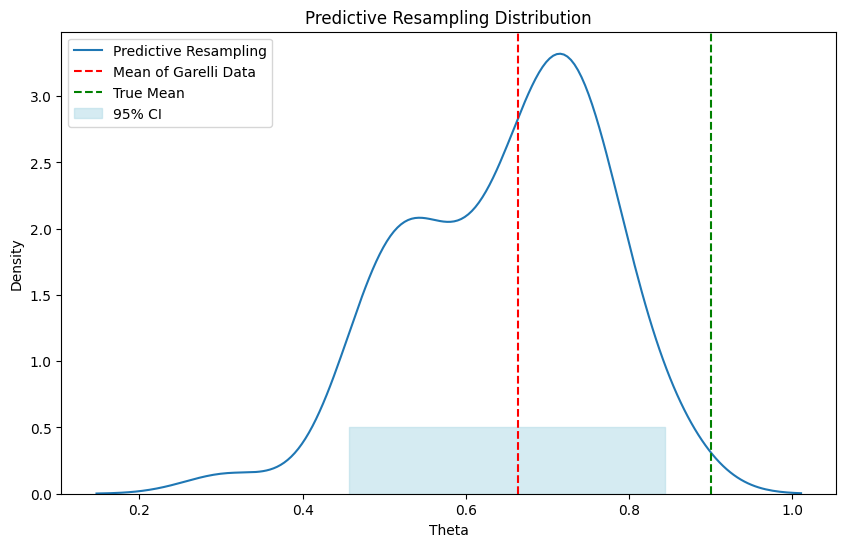

In [42]:
from src.predictions import confidence_interval
# 95% CI
ci_lb, ci_median, ci_ub = confidence_interval(pr_theta_dist[2000], alpha=0.05)

# Plotting the results
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.kdeplot(pr_theta_dist[2000], label='Predictive Resampling')
plt.axvline(np.mean(garelli_data), color='red', linestyle='--', label='Mean of Garelli Data')
plt.axvline(np.dot(weights, mus), color='green', linestyle='--', label='True Mean')
plt.fill_betweenx([0, 0.5], ci_lb, ci_ub, color='lightblue', alpha=0.5, label='95% CI')
plt.xlabel('Theta')
plt.ylabel('Density')
plt.title('Predictive Resampling Distribution')
plt.legend()
plt.show()